In [2]:
import pandas as pd
import numpy as np
import os

In [124]:
df = pd.read_csv('../data/Smarket.csv')

In [4]:
df.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


In [5]:
print(df.describe())

              Year         Lag1         Lag2         Lag3         Lag4  \
count  1250.000000  1250.000000  1250.000000  1250.000000  1250.000000   
mean   2003.016000     0.003834     0.003919     0.001716     0.001636   
std       1.409018     1.136299     1.136280     1.138703     1.138774   
min    2001.000000    -4.922000    -4.922000    -4.922000    -4.922000   
25%    2002.000000    -0.639500    -0.639500    -0.640000    -0.640000   
50%    2003.000000     0.039000     0.039000     0.038500     0.038500   
75%    2004.000000     0.596750     0.596750     0.596750     0.596750   
max    2005.000000     5.733000     5.733000     5.733000     5.733000   

             Lag5       Volume        Today  
count  1250.00000  1250.000000  1250.000000  
mean      0.00561     1.478305     0.003138  
std       1.14755     0.360357     1.136334  
min      -4.92200     0.356070    -4.922000  
25%      -0.64000     1.257400    -0.639500  
50%       0.03850     1.422950     0.038500  
75%       0

In [7]:
print(df.corr()) # get the correlation matrix

            Year      Lag1      Lag2      Lag3      Lag4      Lag5    Volume  \
Year    1.000000  0.029700  0.030596  0.033195  0.035689  0.029788  0.539006   
Lag1    0.029700  1.000000 -0.026294 -0.010803 -0.002986 -0.005675  0.040910   
Lag2    0.030596 -0.026294  1.000000 -0.025897 -0.010854 -0.003558 -0.043383   
Lag3    0.033195 -0.010803 -0.025897  1.000000 -0.024051 -0.018808 -0.041824   
Lag4    0.035689 -0.002986 -0.010854 -0.024051  1.000000 -0.027084 -0.048414   
Lag5    0.029788 -0.005675 -0.003558 -0.018808 -0.027084  1.000000 -0.022002   
Volume  0.539006  0.040910 -0.043383 -0.041824 -0.048414 -0.022002  1.000000   
Today   0.030095 -0.026155 -0.010250 -0.002448 -0.006900 -0.034860  0.014592   

           Today  
Year    0.030095  
Lag1   -0.026155  
Lag2   -0.010250  
Lag3   -0.002448  
Lag4   -0.006900  
Lag5   -0.034860  
Volume  0.014592  
Today   1.000000  


In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt

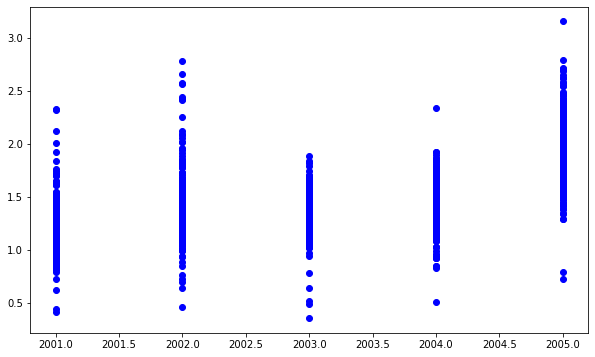

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df['Year'], df['Volume'], 'bo')

<AxesSubplot:title={'center':'Volume'}, xlabel='Year'>

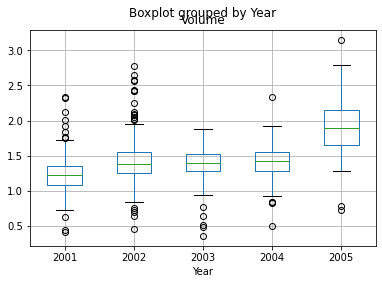

In [29]:
df.boxplot(column='Volume', by='Year') # boxplots of volume by years, can see increasing trend more easily

In [69]:
import statsmodels.api as sm

In [91]:
# first we try logistic regression
y = df['Direction'].apply(lambda x: 1 if x == 'Up' else 0) # map data
x = df[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']]
x = sm.add_constant(x) # remember to always do this :(
results = sm.GLM(y, x, family=sm.families.Binomial()).fit() # you could also just use Logit, but this is more general

In [92]:
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Direction   No. Observations:                 1250
Model:                            GLM   Df Residuals:                     1243
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -863.79
Date:                Wed, 20 Jul 2022   Deviance:                       1727.6
Time:                        15:20:20   Pearson chi2:                 1.25e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.002868
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1260      0.241     -0.523      0.6

In [137]:
pred = results.predict(x)
format_pred = pred.apply(lambda x: 'Up' if x > 0.5 else 'Down') # from this we can calculate error rates
combined = np.vstack((df['Direction'], format_pred)).T
tabled = pd.DataFrame(combined)
tabled.columns = ['Direction', 'Predicted']
print(tabled.groupby(['Direction', 'Predicted']).size()) # error rates
print((format_pred == df['Direction']).mean()) # error rate

Direction  Predicted
Down       Down         145
           Up           457
Up         Down         141
           Up           507
dtype: int64
0.5216


In [140]:
# now we do linear discriminant
# we use sklearn now cause this statsmodels doesn't support it oops
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [192]:
df_train = df[df['Year'] < 2005]
x_new = df_train[['Lag1', 'Lag2']]
y_new = df_train['Direction']
lda = LinearDiscriminantAnalysis()
lda.fit(x_new, y_new)
# for some reasons coefficients are different but same results as ISL, confidence vs scaling?
print('classes:', lda.classes_)
print('coefficients:', lda.coef_) 
print('means:\n', lda.means_)
# if result of linear discrminant is large, we predict increase, else we predict decrease in market

classes: ['Down' 'Up']
coefficients: [[-0.05544078 -0.0443452 ]]
means:
 [[ 0.04279022  0.03389409]
 [-0.03954635 -0.03132544]]


In [193]:
transform = np.vectorize(lambda x: 1 if x > 0 else 0)
convert = np.vectorize(lambda x: 1 if x == 'Up' else 0)
(transform(lda.decision_function(x_new)) == convert(lda.predict(x_new))).sum() # two equivalent methods
# note that decision function doesn't apply ay logistic transform

998

In [194]:
# quadratic discriminant analysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()
qda.fit(x_new, y_new)
# for some reasons coefficients are different but same results as ISL, confidence vs scaling?
print('classes:', qda.classes_)
print('coefficients:', qda.rotations_) 
print('means:\n', qda.means_)

classes: ['Down' 'Up']
coefficients: [array([[ 0.57172606,  0.82044458],
       [-0.82044458,  0.57172606]]), array([[-0.84630247, -0.53270267],
       [ 0.53270267, -0.84630247]])]
means:
 [[ 0.04279022  0.03389409]
 [-0.03954635 -0.03132544]]


In [196]:
from sklearn.neighbors import KNeighborsClassifier

In [221]:
x_std = x_new # standardize the data, this matters because KNN is based off distance
x_std = (x_std - x_std.mean()) / x_std.std()

In [222]:
knn = KNeighborsClassifier(n_neighbors=3) # KNN classifier
results = knn.fit(x_std, y_new)
print(knn.score(x_std, y_new)) # accuracy

0.7545090180360722
